In [ ]:
#改变当前工作目录到谷歌云盘的路径
from google.colab import drive
drive.mount('/content/drive/')
import os
path="/content/drive/My Drive/Colab Notebooks/"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive/


['Untitled5.ipynb',
 'BRAIN-LARGE-scVI.ipynb',
 'BRAIN-SMALL.ipynb',
 'BRAIN-LARGE.ipynb',
 'Untitled (1)',
 'BRAIN-LARGE-prepro.ipynb',
 'learn_scanpy.ipynb',
 'Untitled0.ipynb',
 'scvi_RETINA.ipynb',
 '“preprocessing.ipynb”的副本',
 'Untitled1.ipynb',
 'scvi_CORTEX.ipynb',
 'reproduce_scvi_tutorial.ipynb',
 'scScope.ipynb',
 '“ae_mnist_conv_jax.ipynb”的副本 (1)',
 '“ae_mnist_conv_jax.ipynb”的副本',
 '““ae-dae_on_mnist”的副本”的副本',
 '“ae_dae_on_fashionmnist”的副本',
 'Untitled',
 'cauculate_p.ipynb',
 'Untitled2.ipynb',
 'Untitled3.ipynb',
 'self_ae.ipynb',
 'self_vae.ipynb',
 'data',
 'new_IS.ipynb',
 'IS.ipynb',
 'fashionmnist_images',
 'FID.ipynb',
 'FID_nb.ipynb',
 'my_vae.ipynb',
 'my_ae.ipynb',
 'my_sae.ipynb',
 'my_dae.ipynb',
 'my_diffusion.ipynb',
 'my_gan.ipynb']

In [ ]:
#加载相应包
!pip install memory_profiler
%load_ext memory_profiler
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch import optim


torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

input_dim = 100
batch_size = 64
lr = 2e-4
num_epoch = 10
input_size = 28*28



In [ ]:
#下载数据
train_data = datasets.FashionMNIST(
  root = "data",
  train = True,
  transform = transforms.ToTensor(),
  download = True,
)
test_data = datasets.FashionMNIST(
  root = "data",
  train = False,
  transform = transforms.ToTensor(),
  download = True,
)
train_loader = DataLoader(train_data, batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size, shuffle = True)

In [ ]:
#定义网络模型
class Generator(nn.Module):
  def __init__(self, input_dim):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(input_dim, 32 * 32)
    self.br1 = nn.Sequential(
        nn.BatchNorm1d(1024),
        nn.ReLU()
    )
    self.fc2 = nn.Linear(32 * 32, 128 * 7 * 7)
    self.br2 = nn.Sequential(
        nn.BatchNorm1d(128 * 7 * 7),
        nn.ReLU()
    )
    self.conv1 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
    )
    self.conv2 = nn.Sequential(
        nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.br1(self.fc1(x))
    x = self.br2(self.fc2(x))
    x = x.reshape(-1, 128, 7, 7)
    x = self.conv1(x)
    output = self.conv2(x)
    return output

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 32, 5, stride=1),
        nn.LeakyReLU(0.2)
    )
    self.pl1 = nn.MaxPool2d(2, stride=2)
    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, 5, stride=1),
        nn.LeakyReLU(0.2)
    )
    self.pl2 = nn.MaxPool2d(2, stride=2)
    self.fc1 = nn.Sequential(
        nn.Linear(64 * 4 * 4, 1024),
        nn.LeakyReLU(0.2)
    )
    self.fc2 = nn.Sequential(
        nn.Linear(1024, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.pl1(x)
    x = self.conv2(x)
    x = self.pl2(x)
    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    output = self.fc2(x)
    return output

In [ ]:
#定义loss 训练ha
G = Generator(input_dim).to(device)
D = Discriminator().to(device)
optim_G = torch.optim.Adam(G.parameters(), lr=lr)
optim_D = torch.optim.Adam(D.parameters(), lr=lr)
loss_fn = nn.BCELoss()

def training(x):
  real_x = x.to(device)
  real_output = D(real_x)
  real_loss = loss_fn(real_output, torch.ones_like(real_output).to(device))

  fake_x = G(torch.randn([batch_size, input_dim]).to(device)).detach()
  fake_output = D(fake_x)
  fake_loss = loss_fn(fake_output, torch.zeros_like(fake_output).to(device))

  loss_D = real_loss + fake_loss

  optim_D.zero_grad()
  loss_D.backward()
  optim_D.step()

  fake_x = G(torch.randn([batch_size, input_dim]).to(device))
  fake_output = D(fake_x)
  loss_G = loss_fn(fake_output, torch.ones_like(fake_output).to(device))

  optim_G.zero_grad()
  loss_G.backward()
  optim_G.step()

  return loss_D, loss_G



In [ ]:
#训练
%%memit
for epoch in range(num_epoch):
  for step, (images, labels) in enumerate(train_loader):


    loss_D, loss_G = training(images)

  print("Epoch [{}/{}], Loss_D: {:.4f}, Loss_G: {:.4f} ".format(epoch+1, num_epoch, loss_D.item(), loss_G.item()))

  x = torch.randn(64, input_dim).to(device)
  img = G(x)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/10], Loss_D: 0.9088, Loss_G: 1.4121 
Epoch [2/10], Loss_D: 1.0380, Loss_G: 1.4897 
Epoch [3/10], Loss_D: 1.2941, Loss_G: 1.1108 
Epoch [4/10], Loss_D: 1.0094, Loss_G: 0.9958 
Epoch [5/10], Loss_D: 1.1921, Loss_G: 0.9817 
Epoch [6/10], Loss_D: 1.0020, Loss_G: 1.0069 
Epoch [7/10], Loss_D: 1.1750, Loss_G: 1.0660 
Epoch [8/10], Loss_D: 1.1305, Loss_G: 1.0371 
Epoch [9/10], Loss_D: 1.0737, Loss_G: 1.1340 
Epoch [10/10], Loss_D: 1.1949, Loss_G: 1.0941 
peak memory: 1220.72 MiB, increment: 445.09 MiB


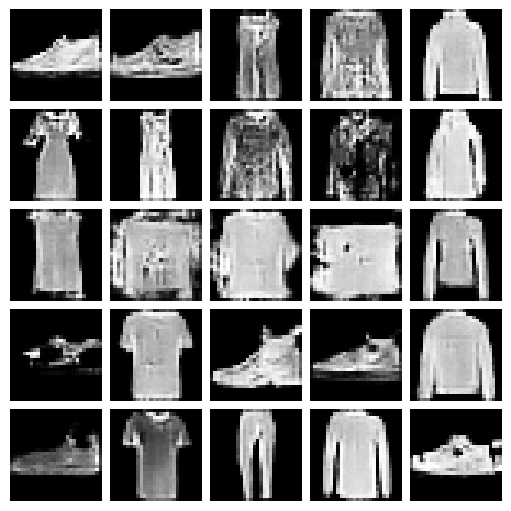

In [ ]:
#生成
z = torch.randn(25, input_dim).to(device)
generated_images = G(z).cpu()

# DDPM生成MNIST新数据图片
fig = plt.figure(figsize=(5, 5), constrained_layout=True)
gs = fig.add_gridspec(5, 5)

imgs = generated_images.detach().reshape(5, 5, 28, 28)
for n_row in range(5):
  for n_col in range(5):
    f_ax = fig.add_subplot(gs[n_row, n_col])
    f_ax.imshow((imgs[n_row, n_col]), cmap="gray")
    f_ax.axis("off")


In [ ]:
#下载生成数据
import os
from PIL import Image
import torch

# 检查目录是否存在，如果不存在则创建
directory = '/content/drive/My Drive/gan_fashionmnist_images/'
if not os.path.exists(directory):
    os.makedirs(directory)

num_samples = 1000
# 假设latent_size已经定义，模型已加载到GPU
latent_vectors = torch.randn(num_samples, input_dim).to(device)

with torch.no_grad():
    # 生成图像并转移到CPU
    generated_images = G(latent_vectors).cpu()
    # 重塑图像数据为[num_samples, 1, 28, 28]
    generated_images = generated_images.view(num_samples, 1, 28, 28)

for i, image in enumerate(generated_images):
    # 去掉单一的颜色通道维度，因为这是灰度图像
    image = image.squeeze(0)*255.0  # 将图像从[1, 28, 28]变为[28, 28]

    # 将PyTorch张量转换为NumPy数组，并转换数据类型为uint8
    pil_image = Image.fromarray(image.numpy().astype(np.uint8)).convert('RGB')
    pil_image.save(f'/content/drive/My Drive/gan_fashionmnist_images/image_{i:05d}.png')